# Testing Xskillscore

In [5]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

In documentation, obs denotes observations (y or verification data) and fct is some forecast (y_hat)

In [2]:
ozone = xr.load_dataset("ozone_prediction_ds.nc")

In [4]:
ozone

<xarray.Dataset>
Dimensions:       (lat: 48, lon: 120, time: 460)
Coordinates:
  * time          (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2014-08-31
  * lon           (lon) float64 -180.0 -178.5 -177.0 -175.5 ... -4.5 -3.0 -1.5
  * lat           (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 64.5 66.0 67.5 69.0 70.5
Data variables:
    observation   (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    all_features  (time, lat, lon) float32 3.473 5.098 8.176 ... 17.34 5.696
    no_geop       (time, lat, lon) float32 2.079 3.837 5.716 ... 5.948 3.62
    no_d2m        (time, lat, lon) float32 0.7502 2.948 3.094 ... 5.189 1.359
    no_msl        (time, lat, lon) float32 2.559 5.499 6.836 ... 8.001 2.323
    no_temp       (time, lat, lon) float32 2.189 3.718 4.02 ... 4.23 4.831 1.47
    no_ssrd       (time, lat, lon) float32 2.268 3.915 4.244 ... 6.515 3.119
    no_sst        (time, lat, lon) float32 2.966 4.853 5.696 ... 5.453 2.901

In [5]:
ozone = ozone.where(ozone.observation > 0)

In [27]:
observations = ozone.observation
forecast = ozone.all_features

In [77]:
grid_r = xs.pearson_r(observations, forecast, dim='time', skipna=True)

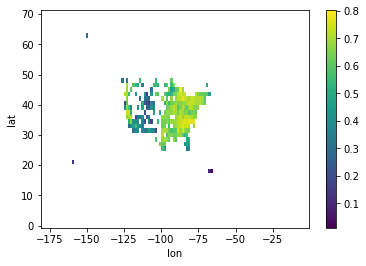

In [78]:
grid_r.plot()

In [74]:
time_r = xs.pearson_r(observations, forecast, dim=['lat', 'lon'], skipna=True)

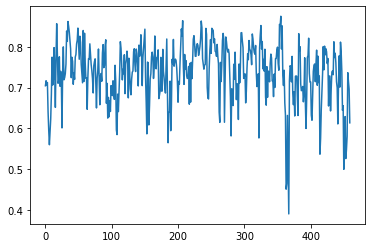

In [76]:
plt.plot(time_r.values)

In [50]:
# dim defaults to None which reduces over all dimensions...
xs.linslope(observations, forecast, skipna=True)

<xarray.DataArray ()>
array(0.7011841, dtype=float32)

In [49]:
xs.linslope(forecast, observations, skipna=True)

<xarray.DataArray ()>
array(0.8023148, dtype=float32)

# Creating non-nan numpy version of observations for computation

In [10]:
obs_ndarray = ozone.observation.values
true_grid_flat = np.nanmean(obs_ndarray, axis=0).flatten()
true_grid_flat = true_grid_flat[~np.isnan(true_grid_flat)]
true_series = np.nanmean(obs_ndarray, axis=(1,2))
true_series = true_series[~np.isnan(true_series)]

<ipython-input-10-d70e3abc4180>:2: RuntimeWarning: Mean of empty slice
  true_grid_flat = np.nanmean(obs_ndarray, axis=0).flatten()


# Using Scipy Stats

Does correlation and linear fit at once

In [309]:
import scipy.stats

In [9]:
import scipy.signal

In [311]:
fit = scipy.stats.linregress(true_grid_flat, grid_flat)

In [11]:
for var in list(ozone.data_vars):
    
    # get numpy array 
    data = getattr(ozone, var)
    array = data.values
    
    # time meaned
    grid_flat = np.nanmean(array, axis=0).flatten()
    grid_flat = grid_flat[~np.isnan(grid_flat)]
    fit = scipy.stats.linregress(true_grid_flat, grid_flat)
    print("{}".format(var), np.round(fit.slope, 3), np.round(fit.rvalue, 3))

observation 1.0 1.0
all_features 0.903 0.948
no_geop 0.892 0.932
no_d2m 0.859 0.929
no_msl 0.833 0.93
no_temp 0.829 0.921
no_ssrd 0.822 0.904
no_sst 0.78 0.919


<ipython-input-11-b2227122ef08>:8: RuntimeWarning: Mean of empty slice
  grid_flat = np.nanmean(array, axis=0).flatten()


In [14]:
true_grid_flat.shape

(273,)

In [18]:
ozone.observation.mean('time').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [19]:
ozone.no_sst.mean('time').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

# Space averaged polyfit is redundant !!!


as you're trying to fit a linear fit to a non-linear time series

# Slope and Correlation using Xskillscore

Make sure you're using the masked dataset, then you skips NaNs using skipna

When you don't feed any dim parameters into xs.pearson_r,
the default is None, which selects all dimensions

**Maybe reproduce the three dimesions calculation?**

### Over all three dimensions

In [85]:
for var in list(ozone.data_vars):
    data = getattr(ozone, var)
    slope = xs.linslope(ozone.observation, data, skipna=True)
    r_correlation = xs.pearson_r(ozone.observation, data, skipna=True)
    print(var, slope.data, r_correlation.data)

observation 1.0 1.0
all_features 0.7011841 0.750046968460083
no_geop 0.68076426 0.7708739638328552
no_d2m 0.64147556 0.7556618452072144
no_msl 0.62727445 0.7610138654708862
no_temp 0.63901955 0.7528954148292542
no_ssrd 0.6406245 0.7515583038330078
no_sst 0.5918807 0.7615857124328613


### Slope and correlation over time (space-averaged)

In [87]:
ozone_series = ozone.observation.mean(dim=['lat', 'lon'])

for var in list(ozone.data_vars):
    data = getattr(ozone, var)
    data_series = data.mean(dim=['lat', 'lon'])
    slope = xs.linslope(ozone_series, data_series, skipna=True)x
    r_correlation = xs.pearson_r(ozone_series, data_series, skipna=True)
    print(var, slope.data, r_correlation.data)

observation 1.0 1.0
all_features 0.87447184 0.8610992431640625
no_geop 0.7867219 0.8133121132850647
no_d2m 0.6759728 0.7729876637458801
no_msl 0.73929226 0.817182719707489
no_temp 0.7508449 0.7807750701904297
no_ssrd 0.8496376 0.8126696944236755
no_sst 0.6967252 0.795539140701294


### Slope and correlation over space (time-averaged)

In [6]:
ozone_grid = ozone.observation.mean(dim=['time'])

for var in list(ozone.data_vars):
    data = getattr(ozone, var)
    data_grid = data.mean(dim=['time'])
    slope = xs.linslope(ozone_grid, data_grid, skipna=True)
    r_correlation = xs.pearson_r(ozone_grid, data_grid, skipna=True)
    print(var, slope.data, r_correlation.data)

observation 1.0 1.0
all_features 0.903385 0.9484509229660034
no_geop 0.891555 0.9320040345191956
no_d2m 0.85940874 0.9289826154708862
no_msl 0.83273786 0.9299617409706116
no_temp 0.82862747 0.9206432700157166
no_ssrd 0.8220891 0.9043521285057068
no_sst 0.780167 0.9186893701553345


In [8]:
xs.pearson_r(ozone_grid, data_grid, skipna=True)

<xarray.DataArray ()>
array(0.91868937)

# Slope and Correlation using numpy

For numpy, average across time then correlate space i.e. compare grid points pairwise (using flatten)

then the other is average across space and then correlate timewise

When fitting using Numpy, you have to deal with NaNs yourself i.e. index them out

### Slope and correlation across time (space-averaged)

In [153]:
# space-averaged

for var in list(ozone.data_vars):
    
    # get numpy array 
    data = getattr(ozone, var)
    array = data.values
    
    # time meaned then nan removed
    series = np.nanmean(array, axis=(1,2))
    series = series[~np.isnan(series)]
    fit = np.polyfit(true_series, series, 1)
    corr = np.corrcoef(true_series, series)
    print("Slope and corr for {} is".format(var), np.round(fit[0],4), np.round(corr[0,1], 4))

Slope and corr for observation is 1.0 1.0
Slope and corr for all_features is 0.8745 0.8611
Slope and corr for no_geop is 0.7867 0.8133
Slope and corr for no_d2m is 0.676 0.773
Slope and corr for no_msl is 0.7393 0.8172
Slope and corr for no_temp is 0.7508 0.7808
Slope and corr for no_ssrd is 0.8496 0.8127
Slope and corr for no_sst is 0.6967 0.7955


### Slope and correlation across space (time-averaged)

In [152]:
# time-averaged

for var in list(ozone.data_vars):
    
    # get numpy array 
    data = getattr(ozone, var)
    array = data.values
    
    # time meaned
    grid_flat = np.nanmean(array, axis=0).flatten()
    grid_flat = grid_flat[~np.isnan(grid_flat)]
    fit = np.polyfit(true_grid_flat, grid_flat, 1)
    corr = np.corrcoef(true_grid_flat, grid_flat)
    print("{}".format(var), np.round(fit[0], 3), np.round(corr[0,1], 3))

observation 1.0 1.0
all_features 0.903 0.948
no_geop 0.892 0.932
no_d2m 0.859 0.929
no_msl 0.833 0.93
no_temp 0.829 0.921
no_ssrd 0.822 0.904
no_sst 0.78 0.919


<ipython-input-152-d6dbb8f62a1c>:10: RuntimeWarning: Mean of empty slice
  grid_flat = np.nanmean(array, axis=0).flatten()


# Correlation using tensorflow tfp.stats

Need to expand dimensions for function use

In [231]:
import tensorflow_probability as tfp

### Correlation across time (space-averaged)

In [237]:
# space-averaged

for var in list(ozone.data_vars):
    
    # get numpy array 
    data = getattr(ozone, var)
    array = data.values
    
    # time meaned then nan removed
    series = np.nanmean(array, axis=(1,2))
    series = series[~np.isnan(series)]

    corr = tfp.stats.correlation(np.expand_dims(true_series, -1),
                                 np.expand_dims(series, -1)).numpy()
    
    print("Corr for {} is".format(var), np.round(corr, 4))

Corr for observation is [[1.]]
Corr for all_features is [[0.8611]]
Corr for no_geop is [[0.8133]]
Corr for no_d2m is [[0.773]]
Corr for no_msl is [[0.8172]]
Corr for no_temp is [[0.7808]]
Corr for no_ssrd is [[0.8127]]
Corr for no_sst is [[0.7955]]


### Correlation across space (time-averaged)

In [240]:
# time-averaged

for var in list(ozone.data_vars):
    
    # get numpy array 
    data = getattr(ozone, var)
    array = data.values
    
    # time meaned
    grid_flat = np.nanmean(array, axis=0).flatten()
    grid_flat = grid_flat[~np.isnan(grid_flat)]
    
    corr = tfp.stats.correlation(np.expand_dims(true_grid_flat, -1),
                                 np.expand_dims(grid_flat, -1)).numpy()
    
    print("Corr for {}".format(var), np.round(corr, 4))

Corr for observation [[1.]]
Corr for all_features [[0.9485]]
Corr for no_geop [[0.932]]
Corr for no_d2m [[0.929]]
Corr for no_msl [[0.93]]
Corr for no_temp [[0.9206]]
Corr for no_ssrd [[0.9044]]
Corr for no_sst [[0.9187]]


<ipython-input-240-1fb328f42450>:10: RuntimeWarning: Mean of empty slice
  grid_flat = np.nanmean(array, axis=0).flatten()


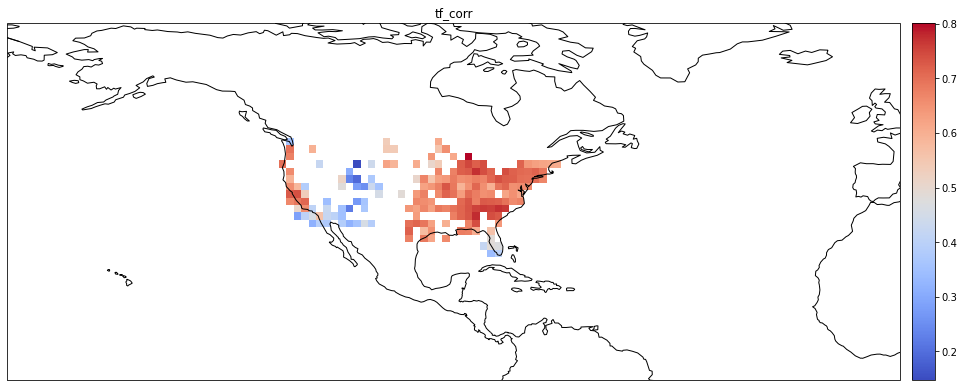

In [234]:
plot_grid(tf_corr, 'tf_corr')

# Checking and plotting

TensorFlow correlation (using tfp.stats) and Xskillscore pearson_r give you two different things...

Correlation over flat arrays is okay.

Your high correlation in the grid case may be due to the inclusion of NaNs?? -> no, you've indexed them out.

Well in the Xs case, you're having to take the correlation over 

In [274]:
xs.pearson_r(ozone.observation, ozone.all_features,
             skipna=True).values

array(0.75004697)

In [273]:
xs.pearson_r(ozone.observation, ozone.all_features,
                            dim=['time', 'lat', 'lon'], skipna=True).values

array(0.75004697)

In [120]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature 

# for plotting

eralons = np.arange(-180, 0, 1.5)
eralats = np.arange(0, 72, 1.5)

def plot_grid(array, title, color='coolwarm'):
    fig = plt.figure(figsize=(16, 10))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent((-180, 0, 0, 72), crs=ccrs.PlateCarree())
    ax.coastlines()
    
    X1,Y1 = np.meshgrid(eralons, eralats)
    plt.pcolormesh(X1, Y1, array, transform=ccrs.PlateCarree(), cmap=color)
    plt.title(title)
    
    # aligns the color to plot size
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(cax = cax)

In [286]:
tf_corr_grid = tfp.stats.correlation(np.expand_dims(ozone.observation.data,-1),
                                     np.expand_dims(ozone.all_features.data, -1))
tf_corr_grid = tf_corr_grid.numpy().squeeze()

In [275]:
xs_corr_grid = xs.pearson_r(ozone.observation, ozone.all_features, dim='time', skipna=True).values

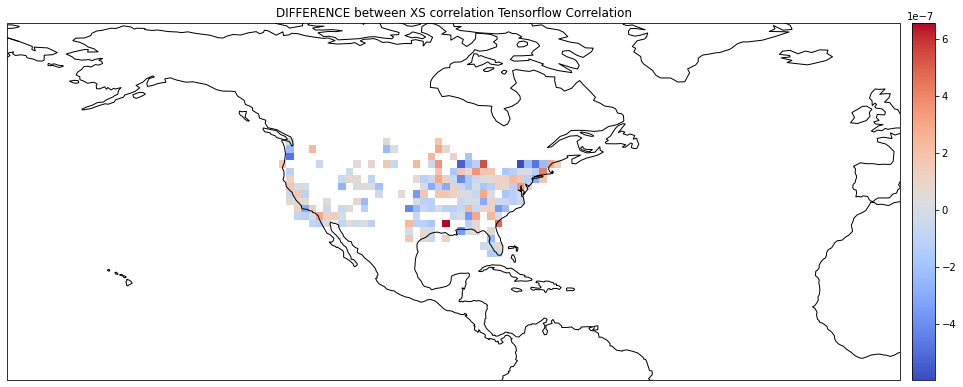

In [278]:
plot_grid(xs_corr_grid - tf_corr_grid, "DIFFERENCE between XS correlation Tensorflow Correlation")